[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/real-itu/modern-ai-course/blob/master/lecture-02/lab.ipynb)

# Lab 2 - Adversarial Search

[Connect 4](https://en.wikipedia.org/wiki/Connect_Four) is a classic board game in which 2 players alternate placing markers in columns, and the goal is to get 4 in a row, either horizontally, vertically or diagonally. See the short video below

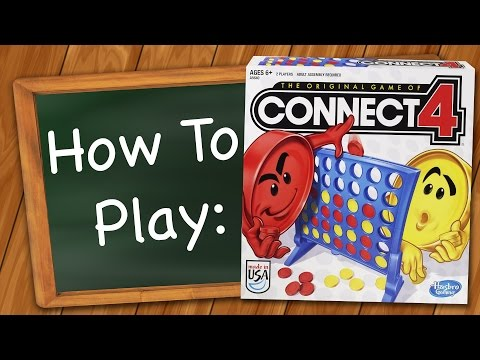

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("ylZBRUJi3UQ")

The game is implemented below. It will play a game where both players take random (legal) actions. The MAX player is represented with a X and the MIN player with an O. The MAX player starts. Execute the code.

In [5]:
### import random
from copy import deepcopy
from typing import Sequence
import math

NONE = '.'
MAX = 'X'
MIN = 'O'
COLS = 7
ROWS = 6
N_WIN = 4


class ArrayState:
    #class that defines the state of the game
    def __init__(self, board, heights, n_moves):
        self.board = board
        self.heights = heights
        self.n_moves = n_moves

    @staticmethod
    def init():
        board = [[NONE] * ROWS for _ in range(COLS)]
        return ArrayState(board, [0] * COLS, 0)


def result(state: ArrayState, action: int) -> ArrayState:
    """Insert in the given column."""
    assert 0 <= action < COLS, "action must be a column number"

    if state.heights[action] >= ROWS:
        raise Exception('Column is full')

    player = MAX if state.n_moves % 2 == 0 else MIN

    board = deepcopy(state.board)
    board[action][ROWS - state.heights[action] - 1] = player

    heights = deepcopy(state.heights)
    heights[action] += 1

    return ArrayState(board, heights, state.n_moves + 1)


def actions(state: ArrayState) -> Sequence[int]:
    return [i for i in range(COLS) if state.heights[i] < ROWS]
    
def ordered_actions(state: ArrayState) -> Sequence[int]:
    #order the actions so we prioritize the middle columns first
    act = [i for i in range(COLS) if state.heights[i] < ROWS]
    new_act = []
    for i in [3,2,4,1,5,0,6]:
        if i in act:
            new_act.append(i)
    return new_act
    

def utility(state: ArrayState) -> float:
    """Get the winner on the current board."""

    board = state.board

    def diagonalsPos():
        """Get positive diagonals, going from bottom-left to top-right."""
        for di in ([(j, i - j) for j in range(COLS)] for i in range(COLS + ROWS - 1)):
            yield [board[i][j] for i, j in di if i >= 0 and j >= 0 and i < COLS and j < ROWS]

    def diagonalsNeg():
        """Get negative diagonals, going from top-left to bottom-right."""
        for di in ([(j, i - COLS + j + 1) for j in range(COLS)] for i in range(COLS + ROWS - 1)):
            yield [board[i][j] for i, j in di if i >= 0 and j >= 0 and i < COLS and j < ROWS]

    lines = board + \
            list(zip(*board)) + \
            list(diagonalsNeg()) + \
            list(diagonalsPos())

    max_win = MAX * N_WIN
    min_win = MIN * N_WIN
    for line in lines:
        str_line = "".join(line)
        if max_win in str_line:
            return 1
        elif min_win in str_line:
            return -1
    return 0


def score(state: ArrayState, debug = False) -> float:
    """Function to get the score of the board."""

    board = state.board

    def diagonalsPos():
        """Get positive diagonals, going from bottom-left to top-right."""
        for di in ([(j, i - j) for j in range(COLS)] for i in range(COLS + ROWS - 1)):
            yield [board[i][j] for i, j in di if i >= 0 and j >= 0 and i < COLS and j < ROWS]

    def diagonalsNeg():
        """Get negative diagonals, going from top-left to bottom-right."""
        for di in ([(j, i - COLS + j + 1) for j in range(COLS)] for i in range(COLS + ROWS - 1)):
            yield [board[i][j] for i, j in di if i >= 0 and j >= 0 and i < COLS and j < ROWS]
    
    #get the diagonal lines
    pos_diago = list(diagonalsPos())
    neg_diago = list(diagonalsNeg())

    #remove the lines that dont contain at least 4 positions, since those cant win the game anyway
    pos_diago = [elem for elem in pos_diago if len(elem)>=4]
    neg_diago = [elem for elem in neg_diago if len(elem)>=4]
    
        
    lines = board + \
            list(zip(*board)) + \
            pos_diago + \
            neg_diago

    
    #Define the combination of pieces we are going to watch out for in order to assign a score to the stawte
    #Piece combinations for max player
    max_four = MAX * 4
    
    max_three_a = NONE + MAX * 3
    max_three_b = MAX * 3 + NONE
    max_three_double = NONE + MAX * 3 + NONE
    
    max_two_a = NONE + MAX * 2
    max_two_b = MAX * 2 + NONE
    
    max_one_a = NONE + MAX * 1 
    max_one_b = MAX * 1 + NONE
    
    max_almostfour_a = MAX + NONE + MAX + MAX
    max_almostfour_b = MAX + MAX + NONE + MAX
    
    #Piece combinations for min player
    min_four = MIN * 4
    
    min_three_a = NONE + MIN * 3
    min_three_b = MIN * 3 + NONE
    min_three_double = NONE + MIN * 3 + NONE
    
    min_two_a = NONE + MIN * 2
    min_two_b = MIN * 2 + NONE
    
    min_one_a = NONE + MIN * 1 
    min_one_b = MIN * 1 + NONE
    
    min_almostfour_a = MIN + NONE + MIN + MIN
    min_almostfour_b = MIN + MIN + NONE + MIN
    
    #The value that these combinations will be given
    four = math.inf
    three = 300
    three_double = math.inf
    two = 20
    one = 5

    #The values that both of the players accumulate in a given state
    max_acumulated = 0
    min_acumulated = 0
    
    for line in lines:
        #Check if we find those patterns and add score to the player
        str_line = "".join(line)
        
        if max_four in str_line:
            max_acumulated += four 
        if max_three_double in str_line:
            max_acumulated += three_double
        if max_three_a in str_line or max_three_b in str_line or max_almostfour_a in str_line or max_almostfour_b in str_line:
            max_acumulated += three
        if max_two_a in str_line or max_two_b in str_line:
            max_acumulated += two
        if max_one_a in str_line or max_one_b in str_line:
            max_acumulated += one

        if min_four in str_line:
            min_acumulated += four    
        if min_three_double in str_line:
            min_acumulated += three_double
        if min_three_a in str_line or min_three_b in str_line or min_almostfour_a in str_line or min_almostfour_b in str_line:
            min_acumulated += three
        if min_two_a in str_line or min_two_b in str_line:
            min_acumulated += two
        if min_one_a in str_line or min_one_b in str_line:
            min_acumulated += one
        
    return max_acumulated - min_acumulated


def terminal_test(state: ArrayState) -> bool:
    return state.n_moves >= COLS * ROWS or utility(state) != 0


def printBoard(state: ArrayState):
    board = state.board
    """Print the board."""
    print('  '.join(map(str, range(COLS))))
    for y in range(ROWS):
        print('  '.join(str(board[x][y]) for x in range(COLS)))
    print()

    
def minimax(state, depth, maximizing_player, alpha, beta):
    #recursive function that returns the best move
    
    if depth == 0 or utility(state) != 0:
        #base condition
        return state, 0
    move = 0

    if maximizing_player:
        max_eval = -math.inf
        for i in ordered_actions(state):
            new_state, new_move = minimax(result(state, i), depth - 1, False, alpha, beta)
            eval_ = score(new_state)
            max_eval = max(max_eval, eval_)
            alpha = max(alpha, eval_)
            if max_eval == eval_:
                move = i
            if beta <= alpha: #prunning
                break
        return state, move

    else:
        min_eval = math.inf
        for i in ordered_actions(state):
            new_state, new_move = minimax(result(state, i), depth - 1, True, alpha, beta)
            eval_ = score(new_state)
            min_eval = min(min_eval, eval_)
            beta = min(beta, eval_)
            if min_eval == eval_:
                move = i
            if beta <= alpha: #prunning
                break
        return state, move

if __name__ == '__main__':
    s = ArrayState.init()
    while not terminal_test(s):
        if s.n_moves % 2 != 0:
            inp = int(input("Pick a column: "))
            a = actions(s)[inp]
            # a = random.choice(actions(s))
        else:
            new_state, new_move = minimax(s, 6, False, -math.inf, math.inf)
            #s = new_state
            a = ordered_actions(s)[new_move]
            print(ordered_actions(s))
            print(a)

        s = result(s, a)
        printBoard(s)
        print("THE SCORE IS: " + str(score(s, True)))
    print(utility(s))


[3, 2, 4, 1, 5, 0, 6]
6
0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  X

THE SCORE IS: 15


Pick a column:  2


0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  O  .  .  .  X

THE SCORE IS: 0
[3, 2, 4, 1, 5, 0, 6]
3
0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: 15


Pick a column:  2


0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  O  .  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: -25
[3, 2, 4, 1, 5, 0, 6]
3
0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: 15


Pick a column:  2


0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  O  .  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: -300
[3, 2, 4, 1, 5, 0, 6]
3
0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: 15


Pick a column:  3


0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  .  .  .  .
.  .  .  O  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: -345
[3, 2, 4, 1, 5, 0, 6]
3
0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  X  .  .  .
.  .  .  O  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: -320


Pick a column:  2


0  1  2  3  4  5  6
.  .  .  .  .  .  .
.  .  .  X  .  .  .
.  .  O  O  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  .
.  .  O  X  .  .  X

THE SCORE IS: -inf
-1


The last number 0, -1 or 1 is the utility or score of the game. 0 means it was a draw, 1 means MAX player won and -1 means MIN player won.

### Exercise 1

Modify the code so that you can play manually as the MIN player against the random AI.

### Exercise 2

Implement standard minimax with a fixed depth search. Modify the utility function to handle non-terminal positions using heuristics. Find a value for the depth such that moves doesn't take longer than approx. 1s to evaluate. See if you can beat your connect4 AI.

### Exercise 3

Add alpha/beta pruning to your minimax. Change your depth so that moves still takes approx 1 second to evaluate. How much deeper can you search? See if you can beat your connect4 AI.

### Exercise 4

Add move ordering. The middle columns are often "better" since there's more winning positions that contain them. Evaluate the moves in this order: [3,2,4,1,5,0,6]. How much deeper can you search now? See if you can beat your connect4 AI

### Exercise 5 - Optional

Improve your AI somehow. Consider 


* Better heuristics
* Faster board representations (look up bitboards)
* Adding a transposition table (see class below)
* Better move ordering

In [3]:
class TranspositionTable:

    def __init__(self, size=1_000_000):
        self.size = size
        self.vals = [None] * size

    def board_str(self, state: ArrayState):
        return ''.join([''.join(c) for c in state.board])

    def put(self, state: ArrayState, utility: float):
        bstr = self.board_str(state)
        idx = hash(bstr) % self.size
        self.vals[idx] = (bstr, utility)

    def get(self, state: ArrayState):
        bstr = self.board_str(state)
        idx = hash(bstr) % self.size
        stored = self.vals[idx]
        if stored is None:
            return None
        if stored[0] == bstr:
            return stored[1]
        else:
            return None